Here, we will construct balances from a phylogenetic tree to explore microbial evolutionary divergences with respect to plant diet.

Make sure that the appropriate files are downloaded.  They can be obtained from the ftp link using the following commands

```bash
wget ftp://ftp.microbio.me/AmericanGut/manuscript-package/1250/deblur_125nt_no_blooms.biom

wget ftp://ftp.microbio.me/AmericanGut/manuscript-package/1250/ag_map_with_alpha.txt
```


In [ ]:
import pandas as pd
from biom import load_table
import matplotlib.pyplot as plt
import numpy as np
from skbio import TreeNode
import seaborn as sns
%matplotlib inline
sns.set_style('ticks')

We will only analyze samples from a small subset -- specifically those samples that only have metabolics samples.

In [2]:
from gneiss.util import match_tips

metadata = pd.read_table('ag_map_with_alpha.txt', index_col=0)
table = load_table('deblur_125nt_no_blooms.biom')
ids = pd.read_table('plants.ids', dtype=np.str, header=None)

# prune tree down
tree = TreeNode.read('ag_tree.tre')
tree = tree.shear(table.ids(axis='observation'))

obs_ids = table.ids(axis='observation')
taxa = [table.metadata(id=i, axis='observation')['taxonomy'] for i in obs_ids]
taxa = pd.DataFrame(taxa, index=obs_ids, 
                    columns=['kingdom', 'phylum', 'class', 'order', 
                             'family', 'genus', 'species'])

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We'll perform some relaxed filters to remove sequences that are likely not interesting.

In [3]:
otu_filter = lambda val, id_, md: val.sum() > 10
var_filter = lambda val, id_, md: np.var(val) > 10
sparse_filter = lambda val, id_, md: (val>0).sum() > 10
id_filter = lambda val, id_, md: id_ in ids[0].values
table = table.filter(id_filter, axis='sample')
table = table.filter(otu_filter, axis='observation')
#table = table.filter(var_filter, axis='observation')
table = table.filter(sparse_filter, axis='observation')

table = pd.DataFrame(np.array(table.matrix_data.todense()).T, 
                     index=table.ids(axis='sample'),
                     columns=table.ids(axis='observation'))

We'll also remove participants that aren't on extreme ends of the spectrum.  Specifically participants that have said that they consume between 10 and 30 plants a week.

In [4]:
from gneiss.util import match
def preprocess_plants(x):
    if x in 'Less than 5' or x in '6 to 10':
        return 'Less than 10'
    elif x in 'More than 30':
        return 'More than 30'
    else:
        return np.nan
metadata['cleaned_plants'] = metadata.types_of_plants.apply(preprocess_plants)
metadata = metadata.dropna(subset=['cleaned_plants'])
table, metadata = match(table, metadata)

Since we have seen well defined patterns in the Partial Least Squares analysis, we will use Random Forests as a feature selection method to remove features that poorly explain the differences due to plant diet.

In [5]:
from sklearn.exceptions import ConvergenceWarning
from skbio.stats.composition import closure
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing
from skbio.stats.composition import clr, centralize, multiplicative_replacement
from numpy.random import RandomState

le = preprocessing.LabelEncoder()
le.fit(metadata.cleaned_plants)
y = le.transform(metadata.cleaned_plants)
clf = ExtraTreesClassifier(100, random_state=0)
clf.fit(table.values, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [6]:
table = table.loc[:, clf.feature_importances_>0.004]

With this filtered table, we'll align the tree tips with the table.

In [7]:
from gneiss.util import rename_internal_nodes
table, tree = match_tips(table, tree)
tree = rename_internal_nodes(tree)

Now we'll perform the ilr transform to obtain the balance.  Remember, we cannot have zeros prior to using the ilr transform, so we'll use the `multiplicative_replacement` to remove these zeros.

In [8]:
from gneiss.composition import ilr_transform
from skbio.stats.composition import clr, centralize, multiplicative_replacement
from gneiss.cluster import correlation_clustering
ctable = pd.DataFrame(multiplicative_replacement(table),
                      index=table.index, columns=table.columns)
balances = ilr_transform(ctable, tree)

Now we will perform the regression.  Based on the country analysis, country was one of the larger driving factors.  So we'll factor that into our regression model.  This way, we can control for the country effect to investigate differences due to the plant diet.

In [9]:
from gneiss.regression import ols
res = ols("C(country)+C(types_of_plants)", balances, metadata)
res.fit() 

We'll investigate the balance in this case that has the smallest pvalue.

In [10]:
from gneiss.util import NUMERATOR, DENOMINATOR
y = res.pvalues.apply(np.argmin, axis=1)['C(types_of_plants)[T.More than 30]']

num = list(tree.find(y).children[NUMERATOR].subset())
denom = list(tree.find(y).children[DENOMINATOR].subset())

Before we start plotting, we'll want to manipulate the dataframe, since we want to display the contents of the balances separately.

In [11]:
import seaborn as sns
from matplotlib.gridspec import GridSpec

#sns.set_style('ticks')
sns.set(font_scale=1.1)  # crazy big

ctable = pd.DataFrame(closure(table), index=table.index, columns=table.columns)
cmetadata = metadata.copy()
cmetadata['Types of Plants'] = metadata[['cleaned_plants']]
data_num = pd.merge(ctable[num], cmetadata[['Types of Plants']], left_index=True, right_index=True)
data_denom = pd.merge(ctable[denom], cmetadata[['Types of Plants']], left_index=True, right_index=True)
data = pd.concat((data_num, data_denom.iloc[:, :-2]), axis=1)
data = pd.melt(data, id_vars=['Types of Plants'], value_vars=num+denom, 
               value_name='proportion', var_name='sequence')

We'll want to collapse unannotated annotations, so that if a species isn't known, then we'll default to the last identified annotation.

In [12]:
def f(x):
    tabs = ['k__', 'p__', 'c__', 'o__', 'f__', 'g__', 's__']
    x_ = x
    for i in range(1, len(x)):
        if x[i] in tabs:
            x_[i] = x[i-1]
    return x_
taxa = taxa.loc[num+denom]
taxa = taxa.apply(f, axis=1)

Now let's plot the interesting balance below in terms of its numerator and denominator components.

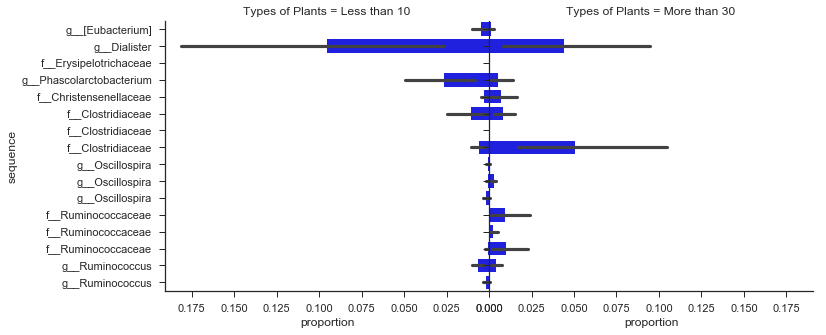

In [17]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
level = 'genus'
sns.set_style('ticks')
data = data.dropna(subset=['proportion'])
data['log_proportion'] = np.log(data['proportion']+1e-5)

num_idx = np.argsort(list(map(lambda x: x[3:].lower(), taxa.loc[num, level].values)))
num_taxa = taxa.loc[[num[i] for i in num_idx], level]

denom_idx = np.argsort(list(map(lambda x: x[3:].lower(), taxa.loc[denom, level].values)))
denom_taxa = taxa.loc[[denom[i] for i in denom_idx], level]

g = sns.factorplot(x='proportion',  
                   y='sequence', 
                   col='Types of Plants',
                   data=data,
                   kind='bar',
                   size=5,
                   aspect=1.5,
                   color='b',
                   col_order=['Less than 10', 'More than 30'],
                   order=list(denom_taxa.index) + list(num_taxa.index),
                   #hue='Types of Plants',
                   sharex=False
)
_ = g.set(yticklabels=taxa.loc[list(denom_taxa.index) + list(num_taxa.index), level].values)
[[ax1, ax2]] = g.axes
max_xlim = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
min_xlim = max(ax1.get_xlim()[0], ax2.get_xlim()[0])
xlim = ([min_xlim, max_xlim])
ax1.set_xlim(max_xlim, min_xlim)
ax2.set_xlim(min_xlim, max_xlim)
ax1.set_position([0.2, 0.125, 0.3, 0.75])
ax2.set_position([0.5, 0.125, 0.3, 0.75])

plt.savefig('Types_of_Plants_cool.pdf')

From here, we can see that there some differences between clade with respect to plant diet.